In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df1 = df[['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']]

In [5]:
df1.isnull().sum()

oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
Normal = len(df.isFraud == 0)
Fraud = len(df.isFraud == 1)
NormalTransaction = Normal/(Normal + Fraud) * 100
FraudulentTransaction = Fraud/(Normal + Fraud) * 100
print(f'No of Normal Transactions:\n{Normal}')
print(f'No of Fraudulent Transactions:\n{Fraud}')
print(f'The fraction of normal transactions is:\n{NormalTransaction:.1f}%')
print(f'The fraction of fraudulent transactions is:\n{FraudulentTransaction:.1f}%')

No of Normal Transactions:
6362620
No of Fraudulent Transactions:
6362620
The fraction of normal transactions is:
50.0%
The fraction of fraudulent transactions is:
50.0%


Here the data is perfectly balanced so we can use Logistic Regression for our classification problem as its simple and works well with balanced dataset

In [7]:
# if we look at the columns newbalancedest and oldbalancedest, we have no info about the costumers whose initial start with M 
# so lets look up the number of costumers with initials M
num_customers_with_M = df[df['nameDest'].str.startswith('M')].shape[0]
num_customers_with_M 

2151495

lets draw a correlation heatmap to Handle multi-collinearity
 

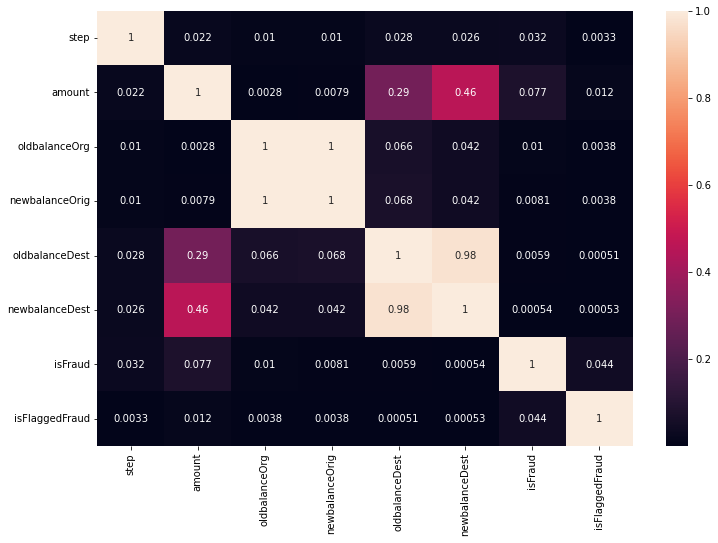

In [8]:
# Checking for correlation between features and drop highly correlated features
correlation_matrix = df.corr().abs()
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True)
# Selecting upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
# Finding index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.90)]
# Dropping highly correlated features
df = df.drop(to_drop, axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in df[['type', 'amount','nameOrig','nameDest']]:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

Time for Model Building

In [10]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

In [11]:
scaler = StandardScaler()
df["NormalizedAmount"] = scaler.fit_transform(df["amount"].values.reshape(-1, 1))
df.drop(["amount"], inplace= True, axis= 1)

In [12]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred = logistic_regression.predict(X_test_scaled)       
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9987321784631698


In [13]:
# Model evaluation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Negative:\n{tn}')
print(f'False Positive:\n{fp}')
print(f'False Negative:\n{fn}')
print(f'True Positive:\n{tp}')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
confusion_matrix = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix")
print(confusion_matrix)

True Negative:
1906351
False Positive:
0
False Negative:
2420
True Positive:
15
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      0.01      0.01      2435

    accuracy                           1.00   1908786
   macro avg       1.00      0.50      0.51   1908786
weighted avg       1.00      1.00      1.00   1908786

Accuracy: 99.87321784631698
Confusion Matrix
[[1906351       0]
 [   2420      15]]


In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def plot_confusion_matrix(confusion_matrix, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

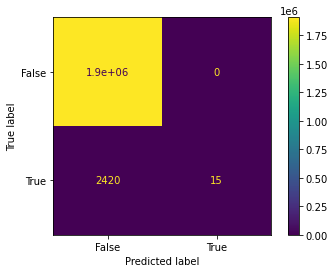

In [15]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

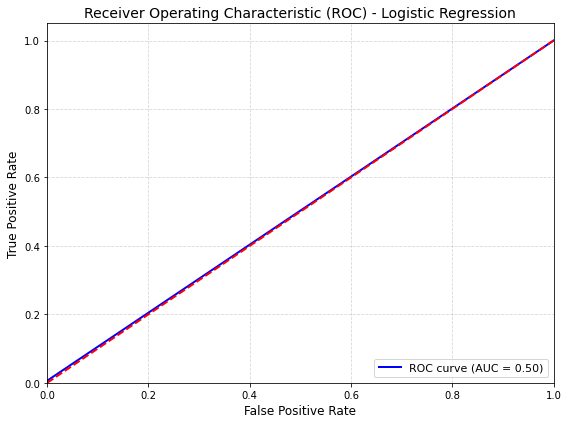

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))  # Setting figure size
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)  # Setting line color, width, and label
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Adding diagonal dashed line
    plt.xlim([0.0, 1.0])  # Setting x-axis limits
    plt.ylim([0.0, 1.05])  # Setting y-axis limits
    plt.xlabel('False Positive Rate', fontsize=12)  # Setting x-axis label and font size
    plt.ylabel('True Positive Rate', fontsize=12)  # Setting y-axis label and font size
    plt.title('Receiver Operating Characteristic (ROC) - ' + title, fontsize=14)  # Setting plot title and font size
    plt.legend(loc='lower right', fontsize=11)  # Adding legend and set font size
    plt.grid(True, linestyle='--', alpha=0.5)  # Adding grid lines with dashed style and transparency
    plt.tight_layout()  # Adjusting layout to prevent overlapping labels
    plt.show()
# Calculating ROC curve and AUC for Logistic Regression
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)  
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc, "Logistic Regression")

Those pre-conceived notions i had about logistic regression being a suitable
method were not right because the model has a chance of predicting right only 50% of the time 
so lets try random forest and decision tree instead

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, y_test) * 100
print(random_forest_score)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))  # Setting figure size
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)  # Setting line color, width, and label
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Adding diagonal dashed line
    plt.xlim([0.0, 1.0])  # Setting x-axis limits
    plt.ylim([0.0, 1.05])  # Setting y-axis limits
    plt.xlabel('False Positive Rate', fontsize=12)  # Setting x-axis label and font size
    plt.ylabel('True Positive Rate', fontsize=12)  # Setting y-axis label and font size
    plt.title('Receiver Operating Characteristic (ROC) - ' + title, fontsize=14)  # Setting plot title and font size
    plt.legend(loc='lower right', fontsize=11)  # Adding legend and set font size
    plt.grid(True, linestyle='--', alpha=0.4)  # Adding grid lines with dashed style and transparency
    plt.tight_layout()  # Adjusting layout to prevent overlapping labels
    plt.show()
# Calculating ROC curve and AUC for Logistic Regression
fpr, tpr, threshold = metrics.roc_curve(y_test, Y_pred_rf)  
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc, "Random Forest Classifier")

As we can see the roc of random forest classifier  is much more better than logistic regression so we will tune this model 
with hyperparameters and find out how much can we improve the chances of fraud detection with it

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_rf_classifier = grid_search.best_estimator_
y_pred_tuned = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_tuned)
print("Accuracy:", accuracy)

What factors contribute to the prediction of fraudulent customers?

Ensure that the request originates from a secure source. Verify the legitimacy of organizations requesting funds. Assess the transaction history of vendors involved.

What preventive measures should be considered during the company's infrastructure update? Utilize only verified and secure applications. Access websites that are known to be secure. Employ secure internet connections, such as VPNs. Keep mobile and laptop security systems up to date. Refrain from responding to unsolicited calls, SMS messages, or emails. Promptly contact the bank if there are any suspicions of fraud or compromised security.

How can the effectiveness of these actions be evaluated after implementation? Review electronic statements provided by the bank. Regularly monitor account activity. Maintain thorough records of all financial transactions.

In [ ]:
Well, I had better results with random forest so hyperparameters tuning would have made my model more better ,
but due to my python kernel not working properly